###1. Import the Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from itertools import combinations_with_replacement
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

###2. Helper Functions -


*   Class Combinations
*   H ( Entropy )
*   hasnan
*   remove_occurences_from_list
*   move_data



In [3]:
def class_combinations(c, n, m=np.inf):
    """ Generates an array of n-element combinations where each element is one of
    the c classes (an integer). If m is provided and m < n^c, then instead of all
    n^c combinations, m combinations are randomly sampled.

    Arguments:
        c {int} -- the number of classes
        n {int} -- the number of elements in each combination

    Keyword Arguments:
        m {int} -- the number of desired combinations (default: {np.inf})

    Returns:
        np.ndarry -- An [m x n] or [n^c x n] array of integers in [0, c)
    """

    if m < c**n:
        # randomly sample combinations
        return np.random.randint(c, size=(int(m), n))
    else:
        p_c = combinations_with_replacement(np.arange(c), n)
        result_array = np.array(list(iter(p_c)), dtype=int)
        return result_array

def H(x, eps=1e-6):
    """ Compute the element-wise entropy of x

    Arguments:
        x {torch.Tensor} -- array of probabilities in (0,1)

    Keyword Arguments:
        eps {float} -- prevent failure on x == 0

    Returns:
        torch.Tensor -- H(x)
    """
    return -(x+eps)*torch.log(x+eps)

def hasnan(x):
    return torch.isnan(x).any()

def remove_occurrences_from_list(l, items):
    # print(items)
    return list(np.setdiff1d(np.array(l, dtype=int),
        np.array(items, dtype=int), assume_unique=True))

def move_data(indices, from_subset, to_subset):
    from_subset.indices = remove_occurrences_from_list(from_subset.indices, indices)
    if isinstance(to_subset.indices, list):
        to_subset.indices.extend(indices)
    elif isinstance(to_subset.indices, np.ndarray):
        to_subset.indices = np.concatenate([to_subset.indices, np.array(indices)])

###3. Acquisition Functions

In [4]:
# Base class for acquisition function.
class Acquirer:
    def __init__(self, batch_size, device):
        self.batch_size = batch_size
        self.processing_batch_size = 128
        self.device = device

    @staticmethod
    def score(model, x):
        """ Parallezied acquisition scoring function

        Arguments:
            model {nn.Module} -- the NN
            x {torch.Tensor} -- datapoints to evaluate

        Returns:
            [torch.Tensor] -- a vector of acquisition scores
        """
        return torch.zeros(len(x))


    def select_batch(self, model, pool_data):
        # score every datapoint in the pool under the model
        pool_loader = torch.utils.data.DataLoader(pool_data,batch_size=self.processing_batch_size, pin_memory=True, shuffle=False)
        scores = torch.zeros(len(pool_data)).to(self.device)
        for batch_idx, (data, _) in enumerate(pool_loader):
            end_idx = batch_idx + data.shape[0]
            scores[batch_idx:end_idx] = self.score(model, data.to(self.device))

        best_local_indices = torch.argsort(scores)[-self.batch_size:]
        best_global_indices = np.array(pool_data.indices)[best_local_indices.cpu().numpy()]
        return best_global_indices

In [12]:
class Random(Acquirer):
    def __init__(self, pool_data, device):
        super(Random, self).__init__(pool_data, device)

    @staticmethod
    def score(model, _):
        return np.random.rand()

class MaxEntropy(Acquirer):
    def __init__(self, batch_size, device):
        super(MaxEntropy, self).__init__(batch_size, device)

    def score(self, model, x):
        with torch.no_grad():
            model.eval()
            outputs = model(x.to(self.device))
            entropy = -torch.sum(outputs * torch.log(outputs + 1e-10), dim=1)
        return entropy

class VariationRatios(Acquirer):
    def __init__(self, batch_size, device):
        super(VariationRatios, self).__init__(batch_size, device)

    def score(self, model, x):
        with torch.no_grad():
            model.eval()
            outputs = torch.stack([model(x.to(self.device)) for _ in range(10)], dim=2)
            mean_outputs = outputs.mean(dim=2)
            variation_ratios = (outputs - mean_outputs.unsqueeze(2)).pow(2).mean(dim=2).sum(dim=1)
        return variation_ratios

class BALD(Acquirer):
    def __init__(self, pool_data, device):
        super(BALD, self).__init__(pool_data, device)

    @staticmethod
    def score(model, x, k=100):
        # I(y;W | x) = H1 - H2 = H(y|x) - E_w[H(y|x,W)]

        with torch.no_grad():
            # take k monte-carlo samples of forward pass w/ dropout
            Y = torch.stack([model(x) for i in range(k)], dim=1)
            H1 = H(Y.mean(axis=1)).sum(axis=1)
            H2 = H(Y).sum(axis=(1,2))/k

            return H1 - H2


class BatchBALD(Acquirer):
    def __init__(self, pool_data, device):
        super(BatchBALD, self).__init__(pool_data, device)
        self.m = 1e4  # number of MC samples for label combinations
        self.num_sub_pool = 500  # number of datapoints in the subpool from which we acquire

    def select_batch(self, model, pool_data, k=100):
        # I(y;W | x) = H1 - H2 = H(y|x) - E_w[H(y|x,W)]

        c = 10 # number of classes

        # performing BatchBALD on the whole pool is very expensive, so we take
        # a random subset of the pool.
        num_extra = len(pool_data) - self.num_sub_pool
        if num_extra > 0:
            sub_pool_data, _ = torch.utils.data.random_split(pool_data, [self.num_sub_pool, num_extra])
        else:
            # even if we don't have enough data left to split, we still need to
            # call random_splot to avoid messing up the indexing later on
            sub_pool_data, _ = torch.utils.data.random_split(pool_data, [len(pool_data), 0])

         # forward pass on the pool once to get class probabilities for each x
        with torch.no_grad():
            pool_loader = torch.utils.data.DataLoader(sub_pool_data,
                batch_size=self.processing_batch_size, pin_memory=True, shuffle=False)
            pool_p_y = torch.zeros(len(sub_pool_data), c, k)
            for batch_idx, (data, _) in enumerate(pool_loader):
                end_idx = batch_idx + data.shape[0]
                pool_p_y[batch_idx:end_idx] = torch.stack([model(data.to(self.device)) for i in range(k)], dim=1).permute(0,2,1)

        # this only need to be calculated once so we pull it out of the loop
        H2 = (H(pool_p_y).sum(axis=(1,2))/k).to(self.device)

        # get all class combinations
        c_1_to_n = class_combinations(c, self.batch_size, self.m)

        # tensor of size [m x k]
        p_y_1_to_n_minus_1 = None

        # store the indices of the chosen datapoints in the subpool
        best_sub_local_indices = []
        # create a mask to keep track of which indices we've chosen
        remaining_indices = torch.ones(len(sub_pool_data), dtype=bool).to(self.device)
        for n in range(self.batch_size):
            # tensor of size [N x m x l]
            p_y_n = pool_p_y[:, c_1_to_n[:, n], :].to(self.device)
            # tensor of size [N x m x k]
            p_y_1_to_n = torch.einsum('mk,pmk->pmk', p_y_1_to_n_minus_1, p_y_n)\
                if p_y_1_to_n_minus_1 is not None else p_y_n

            # and compute the left entropy term
            H1 = H(p_y_1_to_n.mean(axis=2)).sum(axis=1)
            # scores is a vector of scores for each element in the pool.
            # mask by the remaining indices and find the highest scoring element
            scores = H1 - H2
            # print(scores)
            best_local_index = torch.argmax(scores - np.inf*(~remaining_indices)).item()
            # print(f'Best idx {best_local_index}')
            best_sub_local_indices.append(best_local_index)
            # save the computation for the next batch
            p_y_1_to_n_minus_1 = p_y_1_to_n[best_local_index]
            # remove the chosen element from the remaining indices mask
            remaining_indices[best_local_index] = False

        # we've subset-ed our dataset twice, so we need to go back through
        # subset indices twice to recover the global indices of the chosen data
        best_local_indices = np.array(sub_pool_data.indices)[best_sub_local_indices]
        best_global_indices = np.array(pool_data.indices)[best_local_indices]
        return best_global_indices

In [16]:
lr = 0.001
acquisition_batch_size = 64
train_batch_size = 64
num_train = 5000
# Change the initial pool size here. ( GOAL -  Shorten the overall cycle for Active Learning)
num_pool = 1000


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(784, 2048),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2048, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 10))


    def forward(self, x, return_logits=False):
        x = torch.flatten(x, 1)
        logits = self.layers(x)
        if return_logits:
            return logits
        else:
            return F.softmax(logits, 1)


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    print('Training the Model on new Training Set')
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, return_logits=True)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Epoch : {} [{}/{} ({:.0f}%)]\n Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        epoch  = epoch + 1

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, return_logits=True)
            #outputs = model(data)
            #predictions.append(outputs.cpu().numpy())
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('Testing the Model on Test Set \n')
    test_loss /= len(test_loader.dataset)
    accuracy = float(correct) / len(test_loader.dataset)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * accuracy))

    return accuracy,test_loss

def active(model, acquirer, device, data, optimizer):
    train_data, pool_data, test_data = data

    test_losses = []
    test_accuracies = []
    un_test_acc_lst = []
    un_test_pred_lst = []
    while len(pool_data) > 0:
        print(f'Using {acquirer.__class__.__name__} Acquiring technique for Batch Acquisition.\n Current size of the Pool Set: {len(pool_data)}')
        # get the indices of the best batch of data
        batch_indices = acquirer.select_batch(model, pool_data)
        # move that data from the pool to the training set
        move_data(batch_indices, pool_data, train_data)
        # train on it
        train_loader = torch.utils.data.DataLoader(train_data,
            batch_size = train_batch_size, pin_memory=True, shuffle=True)
        train(model, device, train_loader, optimizer, 0)

        # test the accuracy
        test_loader = torch.utils.data.DataLoader(test_data,
            batch_size = train_batch_size, pin_memory=True, shuffle=True)
        test_acc, test_loss = test(model, device, test_loader)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

    return test_accuracies,test_losses

In [14]:
import seaborn as sns

Training the Model on new Training Set
Epoch : 1 [0/5000 (0%)]
 Loss: 2.315302
Epoch : 11 [640/5000 (13%)]
 Loss: 1.367876
Epoch : 21 [1280/5000 (25%)]
 Loss: 1.205094
Epoch : 31 [1920/5000 (38%)]
 Loss: 0.703223
Epoch : 41 [2560/5000 (51%)]
 Loss: 0.666639
Epoch : 51 [3200/5000 (63%)]
 Loss: 0.371248
Epoch : 61 [3840/5000 (76%)]
 Loss: 0.496089
Epoch : 71 [4480/5000 (89%)]
 Loss: 0.852325
Testing the Model on Test Set 

Average loss: 0.3255, Accuracy: 8982/10000 (90%)

Using Random Acquiring technique for Batch Acquisition.
 Current size of the Pool Set: 1000
Training the Model on new Training Set
Epoch : 0 [0/5064 (0%)]
 Loss: 0.283791
Epoch : 10 [640/5064 (12%)]
 Loss: 0.400911
Epoch : 20 [1280/5064 (25%)]
 Loss: 0.353293
Epoch : 30 [1920/5064 (38%)]
 Loss: 0.593293
Epoch : 40 [2560/5064 (50%)]
 Loss: 0.686321
Epoch : 50 [3200/5064 (62%)]
 Loss: 0.475817
Epoch : 60 [3840/5064 (75%)]
 Loss: 0.521977
Epoch : 70 [4480/5064 (88%)]
 Loss: 0.354386
Testing the Model on Test Set 

Average 

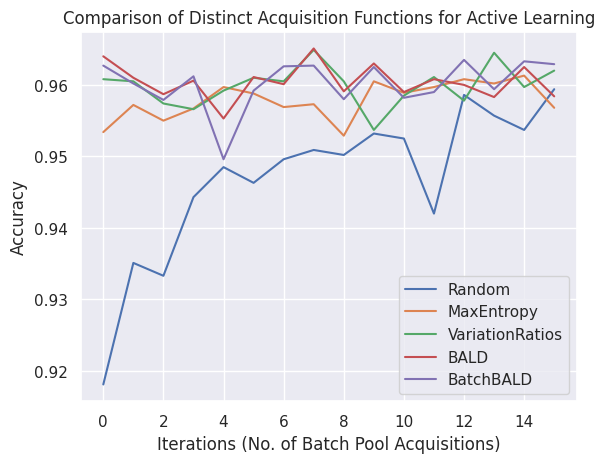

In [17]:
if __name__ == '__main__':
    # set up the GPU if one exists
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # load the dataset and pre-process
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset = datasets.MNIST('data', train=True, download=True,
                       transform=transform)

    subset_indices = np.random.choice(len(dataset), size=num_train+num_pool, replace=False)
    train_indices = subset_indices[:num_train]
    pool_indices = subset_indices[-num_pool:]
    train_data = train_data = torch.utils.data.Subset(dataset, train_indices)
    test_data = datasets.MNIST('data', train=False,
                       transform=transform)
    pretrain_loader = torch.utils.data.DataLoader(train_data,
        batch_size=train_batch_size, pin_memory=True, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,
        batch_size=train_batch_size, pin_memory=True, shuffle=True)

    # init the model and optimizer
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    #Train the model and test after each epoch
    for epoch in range(1, 2):
        train(model, device, pretrain_loader, optimizer, epoch)
        test(model, device, test_loader)\

    pre_acquisition_model_state = model.state_dict()

    #for acquisition_strategy in [Random, BALD, BatchBALD]:
    for acquisition_strategy in [Random, MaxEntropy, VariationRatios,BALD, BatchBALD]:
    #for acquisition_strategy in [Random,MaxEntropy]:
        # reset the model
        model.load_state_dict(deepcopy(pre_acquisition_model_state))
        # init the acquirer
        acquirer = acquisition_strategy(acquisition_batch_size, device)
        # and an optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)
        # get all the data
        train_data = torch.utils.data.Subset(dataset, train_indices)
        pool_data = torch.utils.data.Subset(dataset, pool_indices)
        data = (train_data, pool_data, test_data)
        # train the model with active learning
        accuracies,losses = active(model, acquirer, device, data, optimizer)
        # Test the model with uncertainty
        torch.save(model.state_dict(), f'/content/drive/MyDrive/BML/model_{acquisition_strategy.__name__}.pth')
        # Set Seaborn dark theme
        sns.set_theme(style="darkgrid")
        sns.lineplot(x=range(len(accuracies)), y=accuracies, label=acquisition_strategy.__name__)
        # Plot accuracy with uncertainty

    plt.title('Comparison of Distinct Acquisition Functions for Active Learning')
    plt.xlabel('Iterations (No. of Batch Pool Acquisitions)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()